<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a2/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 execution

In [1]:
%pip install pandas numpy matplotlib transformers dataset tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.9/535.9 kB 13.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Data loading

### Dataset download

In [2]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')
    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [3]:
data_folder = 'Dataset'

In [4]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path=data_folder, url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path=data_folder, url_path=test_url, suffix='test')

### Dataset loading

In [5]:
import numpy as np
import pandas as pd
import json
from os import path
from matplotlib import pyplot as plt

In [6]:
def loadDataset(filename):
    with open(path.join(data_folder, filename)) as file_obj:
        df = json.load(file_obj)["data"]
    print(f'{len(df)} stories / {len(df[0]["questions"])} questions in the first row')

    storyDType = pd.CategoricalDtype(pd.unique([story["story"] for story in df]))
    print(f"{storyDType.categories.size} distinct stories")

    sourceDType = pd.CategoricalDtype(pd.unique([story["source"] for story in df]))
    print(f"{sourceDType.categories.size} distinct sources: {sourceDType.categories}")

    df = np.array([
        [
            sourceDType.categories.get_loc(story["source"]), # Sources factorization
            storyDType.categories.get_loc(story["story"]), # Sources factorization
            story["questions"][question_index]["input_text"],
            story["answers"][question_index]["input_text"],
            story["answers"][question_index]["span_text"],
        ]
        for story in df
        for question_index in range(len(story["questions"]))
        if story["answers"][question_index]["input_text"] != 'unknown'
    ])
    print(f'{df.shape} question-answer pairs x columns')
    print(f'First row: {df[0]}')
    
    # https://marcobonzanini.com/2021/09/15/tips-for-saving-memory-with-pandas/
    # https://pandas.pydata.org/docs/user_guide/categorical.html
    df = pd.DataFrame({
        "source": pd.Series(pd.Categorical.from_codes(df[:,0].astype(np.int16), dtype=sourceDType)),
        "p": pd.Series(pd.Categorical.from_codes(df[:,1].astype(np.int16), dtype=storyDType)),
        "q": df[:,2],
        "a": df[:,3],
        "span": df[:,4],
    })

    return df

In [7]:
train_df = loadDataset("train.json")
train_df.count()

7199 stories / 20 questions in the first row
6605 distinct stories
5 distinct sources: Index(['wikipedia', 'cnn', 'gutenberg', 'race', 'mctest'], dtype='object')
(107276, 5) question-answer pairs x columns
First row: ['0' '0' 'When was the Vat formally opened?'
 'It was formally established in 1475' 'Formally established in 1475']


source    107276
p         107276
q         107276
a         107276
span      107276
dtype: int64

In [8]:
pd.unique(train_df["p"]).size

6605

In [9]:
pd.unique(train_df["span"]).size

99470

In [10]:
pd.unique(train_df["source"]).size

5

In [11]:
train_df.head()

,source,p,q,a,span
0,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475
1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,he Vatican Library is a research library
2,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",Vatican Library is a research library for hist...
3,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",Vatican Library is a research library for hist...
4,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,"March 2014, the Vatican Library began an initi..."


In [12]:
train_df.memory_usage(deep=True)

Index          128
source      107764
p         14241201
q          9110271
a          7714559
span      12090637
dtype: int64

In [13]:
#test_df = loadDataset("test.json")
#test_df.count()

## Data Pre-Processing

### Check unanswerable questions in the Train Dataset

In [14]:
idx = (train_df.a == 'unknown')
unanswerable = train_df[idx]
unanswerable.q.count()

0

All unanswerable questions in the Train Dataset have been already removed.

## Exploratory Data Analysis

In [15]:
train_df["p"][42]

'CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n"Lassiter, will you be my rider?" Jane had asked him. \n\n"I reckon so," he had replied. \n\nFew as the words were, Jane knew how infinitely much they implied. She wanted him to take charge of her cattle and horse and ranges, and save them if that were possible. Yet, though she could not have spoken aloud all she meant, she was perfectly honest with herself. Whatever the price to be paid, she must keep Lassiter close to her; she must shield from him the man who had led Milly Erne to Cottonwoods. In her fear she so controlled her mind that she did not whisper this Mormon\'s name to her own soul, she did not even think it. Besides, beyond this thing she regarded as a sacred obligation thrust upon her, was the need of a helper, of a friend, of a champion in this critical time. If she could rule this gun-man, as Venters had called him, if she could even keep him from shedding blood, what strategy to play his flame and his presence against the g

In [16]:
train_df["q"][42]

'Was Lassiter impressed with the horse?'

In [17]:
train_df["a"][42]

'Yes'

In [18]:
train_df["span"][42]

'When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.'

In [19]:
train_df["source"][42]

'gutenberg'

### Distribution statistics

Sources:

<AxesSubplot:>

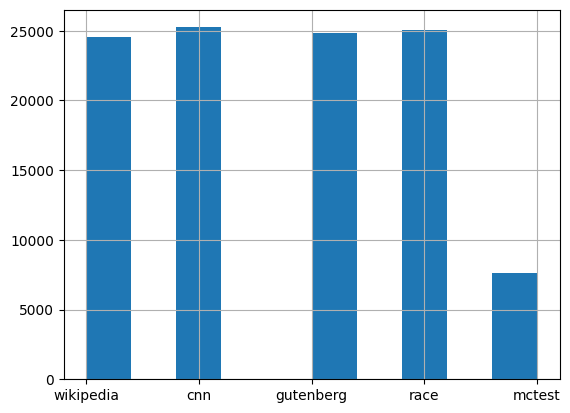

In [20]:
train_df["source"].hist()

Occurrences of 25 most popular stories:

/tmp/ipykernel_6463/3127963000.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  story_counts[:25].plot(kind="bar", figsize=(15,5))


<AxesSubplot:>

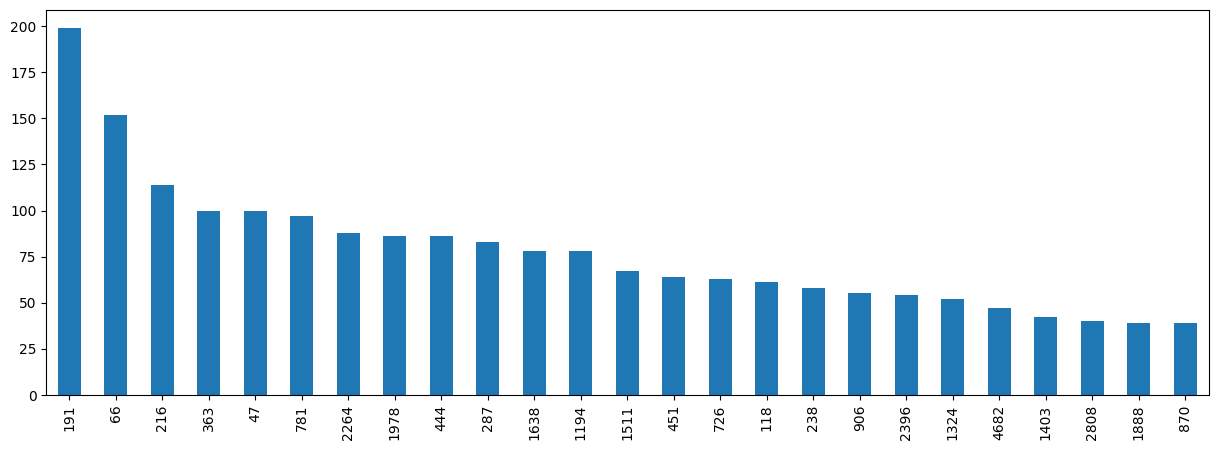

In [21]:
story_counts = train_df["p"].cat.codes.value_counts(sort=True)
story_counts[:25].plot(kind="bar", figsize=(15,5))

Occurrences of 25 least popular stories:

/tmp/ipykernel_6463/3421603498.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  story_counts[-25:-1].plot(kind="bar", figsize=(15,5))


<AxesSubplot:>

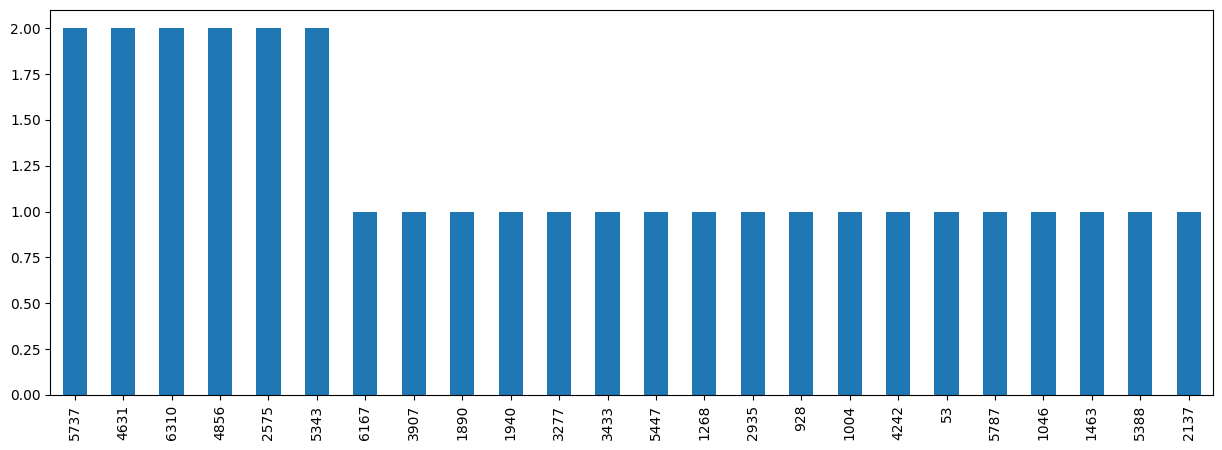

In [22]:
story_counts[-25:-1].plot(kind="bar", figsize=(15,5))

Histogram of story popularities:

<AxesSubplot:>

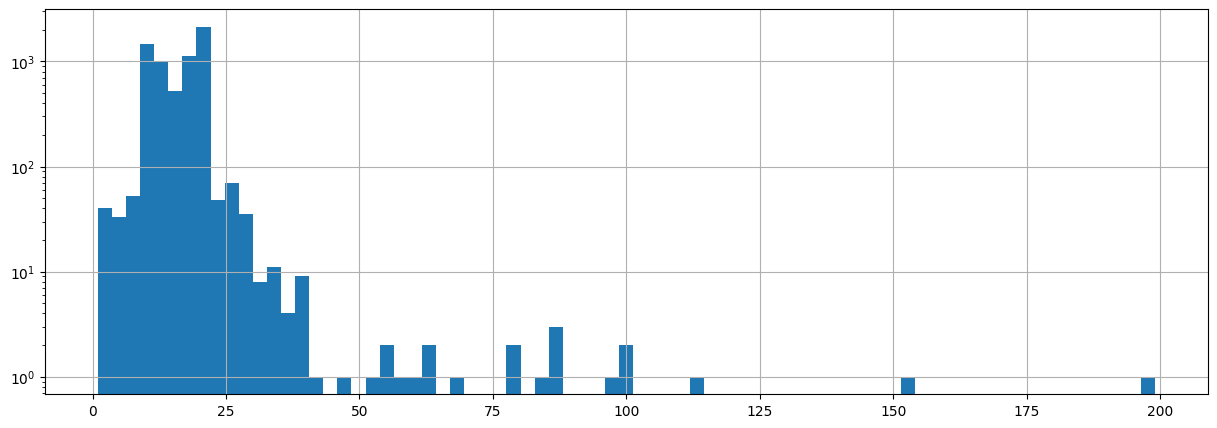

In [23]:
story_counts.hist(log=True,bins=75,figsize=(15,5))

## Train-Validation-Test split

In [24]:
# TODO

## Model definition

### Utilities

In [25]:
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Dict, Callable
import random

2022-12-31 16:31:49.632965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-31 16:31:51.065293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-31 16:31:51.065318: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-31 16:31:51.204447: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-31 16:31:53.199587: W tensorflow/stream_executor/platform/de

In [26]:
def predict_data(model: keras.Model,
                x: np.ndarray,
                prediction_info: Dict):
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [27]:
def compute_f1(model: keras.Model, 
             x: np.ndarray, 
             y: np.ndarray):
    """
    Compute F1_score on the given data with corresponding labels

    :param model: Keras built and possibly trained model
    :param x: data in np.ndarray format
    :param y: ground-truth labels in np.ndarray format

    :return
        score: f1_macro_score
    """
    #predictions on the x set
    prediction_info = {
        'batch_size': 64,
        'verbose': 1
    }
    y_pred = predict_data(model=model, x=x, prediction_info=prediction_info)

    #compute argmax to take the best class for each sample
    y_pred = np.argmax(y_pred, axis=1)
    #compute the f1_macro
    score = f1_score(y, y_pred, average ='macro')
    return score

In [28]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [29]:
import tensorflow as tf
import tensorflow_addons as tfa
from tqdm import tqdm
from transformers import TFAutoModel, AutoTokenizer

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2022-12-31 16:31:57.309692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-31 16:31:57.309924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-31 16:31:57.310131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-31 16:31:57.310381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-31 16:31:57.358632: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

### Question generation $f_\theta(P, Q)$ with text passage $P$ and question $Q$

### Seq2Seq LSTM

In [30]:
class MyTrainer(object):
    """
    Simple wrapper class

    train_op -> uses tf.GradientTape to compute the loss
    batch_fit -> receives a batch and performs forward-backward passes (gradient included)
    """

    def __init__(self, encoder, decoder, max_length):
        self.encoder = encoder
        self.decoder = decoder
        self.max_length = max_length
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)

    @tf.function
    def compute_loss(self, logits, target):
        loss = self.ce(y_true=target, y_pred=logits)
        mask = tf.logical_not(tf.math.equal(target, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            encoder_output, encoder_h, encoder_s = self.encoder({'input_ids': inputs['encoder_input_ids'],
                                                                 'hidden_state': inputs['encoder_state']})

            decoder_input = inputs['decoder_target'][:, :-1]  # ignore <end>
            real_target = inputs['decoder_target'][:, 1:]  # ignore <start>

            decoder.attention.setup_memory(encoder_output)

            decoder_initial_state = self.decoder.build_initial_state(decoder.batch_size, [encoder_h, encoder_s])
            predicted = self.decoder({'input_ids': decoder_input,
                                      'initial_state': decoder_initial_state}).rnn_output

            loss = self.compute_loss(logits=predicted, target=real_target)

        grads = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss

    @tf.function
    def generate(self, input_ids):
        batch_size = input_ids.shape[0]
        encoder_initial_state = [tf.zeros((batch_size, self.encoder.encoder_units)),
                                 tf.zeros((batch_size, self.encoder.encoder_units))]
        encoder_output, encoder_h, encoder_s = self.encoder({
            'input_ids': input_ids,
            'hidden_state': encoder_initial_state
        })

        start_tokens = tf.fill([batch_size], tokenizer.word_index['<start>'])
        end_token = tokenizer.word_index['<end>']

        greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder_instance = tfa.seq2seq.BasicDecoder(cell=self.decoder.wrapped_decoder_cell,
                                                    sampler=greedy_sampler,
                                                    output_layer=self.decoder.generation_dense,
                                                    maximum_iterations=self.max_length)
        self.decoder.attention.setup_memory(encoder_output)

        decoder_initial_state = self.decoder.build_initial_state(batch_size, [encoder_h, encoder_s])
        decoder_embedding_matrix = self.decoder.embedding.variables[0]
        outputs, _, _ = decoder_instance(decoder_embedding_matrix,
                                         start_tokens=start_tokens,
                                         end_token=end_token,
                                         initial_state=decoder_initial_state)
        return outputs

    def translate(self, generated):
        return tokenizer.sequences_to_texts(generated.sample_id.numpy())


class Encoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, encoder_units):
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.encoder_units = encoder_units

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.encoder_lstm = tf.keras.layers.LSTM(self.encoder_units,
                                                 return_sequences=True,
                                                 return_state=True)

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        encoder_output, lstm_hidden, lstm_states = self.encoder_lstm(input_emb, initial_state=inputs['hidden_state'])
        return encoder_output, lstm_hidden, lstm_states

    def initialize(self, batch_size):
        return [tf.zeros((batch_size, self.encoder_units)), tf.zeros((batch_size, self.encoder_units))]


class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, max_sequence_length, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()

        self.max_sequence_length = max_sequence_length
        self.batch_size = batch_size

        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.decoder_units)

        self.attention = tfa.seq2seq.BahdanauAttention(units=self.decoder_units,
                                                       memory=None,
                                                       memory_sequence_length=self.batch_size * [max_sequence_length])

        self.wrapped_decoder_cell = tfa.seq2seq.AttentionWrapper(self.decoder_lstm_cell,
                                                                 self.attention,
                                                                 attention_layer_size=self.decoder_units)

        self.generation_dense = tf.keras.layers.Dense(vocab_size)
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        self.decoder = tfa.seq2seq.BasicDecoder(self.wrapped_decoder_cell,
                                                sampler=self.sampler,
                                                output_layer=self.generation_dense)

    def build_initial_state(self, batch_size, encoder_state):
        initial_state = self.wrapped_decoder_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
        initial_state = initial_state.clone(cell_state=encoder_state)
        return initial_state

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        decoder_output, _, _ = self.decoder(input_emb,
                                            initial_state=inputs['initial_state'],
                                            sequence_length=self.batch_size * [self.max_sequence_length - 1])
        return decoder_output

In [31]:
# Sample
input_sample = [
    "hello there how is it going",
    "this assignment is hellish"
]
output_sample = [
    "<start> it is going well <end>",
    "<start> I agree <end>"
]

batch_size = len(input_sample)

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
tokenizer.fit_on_texts(input_sample + output_sample)

vocab_size = len(tokenizer.word_index) + 1

encoded_input_sample = tokenizer.texts_to_sequences(input_sample)
max_input_length = max([len(item) for item in encoded_input_sample])

encoded_output_sample = tokenizer.texts_to_sequences(output_sample)
max_output_length = max([len(item) for item in encoded_output_sample])

max_sequence_length = max(max_input_length, max_output_length)

encoded_input_sample = tf.keras.preprocessing.sequence.pad_sequences(encoded_input_sample,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)
encoded_output_sample = tf.keras.preprocessing.sequence.pad_sequences(encoded_output_sample,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)

# Test encoder
encoder = Encoder(vocab_size=vocab_size,
                    embedding_dim=50,
                    encoder_units=16)

sample_hidden = encoder.initialize(batch_size=batch_size)
encoder_sample_batch = {
    'input_ids': tf.convert_to_tensor(encoded_input_sample, dtype=tf.int32),
    'hidden_state': sample_hidden
}

sample_output, sample_h, sample_c = encoder(inputs=encoder_sample_batch)
print(f'{sample_output.shape} -- {sample_h.shape} -- {sample_c.shape}')

# Test decoder
decoder = Decoder(vocab_size=vocab_size,
                    embedding_dim=50,
                    decoder_units=16,
                    batch_size=batch_size,
                    max_sequence_length=max_sequence_length)
decoder.attention.setup_memory(sample_output)
initial_state = decoder.build_initial_state(batch_size, [sample_h, sample_c])

decoder_sample_batch = {
    'input_ids': tf.convert_to_tensor(encoded_output_sample, tf.int32),
    'initial_state': initial_state
}
sample_decoder_outputs = decoder(decoder_sample_batch).rnn_output
print(f'{sample_decoder_outputs.shape}')

2022-12-31 16:31:57.526536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(2, 6, 16) -- (2, 16) -- (2, 16)
(2, 5, 16)


In [32]:
# Training
trainer = MyTrainer(encoder=encoder,
                    decoder=decoder,
                    max_length=max_sequence_length)

In [33]:
epochs = 100
for epoch in tqdm(range(epochs)):
    encoder_hidden_state = encoder.initialize(batch_size=batch_size)
    batch = {
        'encoder_input_ids': encoded_input_sample,
        'encoder_state': encoder_hidden_state,
        'decoder_target': encoded_output_sample
    }
    loss = trainer.batch_fit(batch)
    print(f'Loss - {loss}')

    generated = trainer.generate(input_ids=encoded_input_sample)
    translated = trainer.translate(generated)
    print(f'Translated - {translated}')

  0%|          | 0/100 [00:00<?, ?it/s]

Loss - 2.215960741043091


  6%|▌         | 6/100 [00:07<01:30,  1.03it/s]

Translated - ['it it <end> this <UNK> it', 'going i agree agree it it']
Loss - 2.2101049423217773
Translated - ['it it it <end> this it', 'i agree agree it it <end>']
Loss - 2.204186201095581
Translated - ['it it it it it it', 'i agree it it <end> agree']
Loss - 2.1981472969055176
Translated - ['it it it it it it', 'i agree it it <end> <end>']
Loss - 2.1919312477111816
Translated - ['it it it it it it', 'i agree it it <end> <end>']
Loss - 2.18548583984375
Translated - ['it it it it it it', 'i agree it it <end> <end>']
Loss - 2.1787631511688232
Translated - ['it it it it it it', 'i agree it it <end> <end>']
Loss - 2.1717166900634766
Translated - ['it it it it it it', 'i <end> agree <end> <end> <end>']
Loss - 2.1643009185791016
Translated - ['it it it it it it', 'i <end> <end> agree <end> <end>']
Loss - 2.1564693450927734
Translated - ['it it it it it it', 'i <end> <end> <end> <end> <end>']


 16%|█▌        | 16/100 [00:08<00:21,  3.91it/s]

Loss - 2.1481735706329346
Translated - ['it it it it it it', 'it it it it it it']
Loss - 2.13936185836792
Translated - ['it it it it it it', 'it it it it it it']
Loss - 2.129979133605957
Translated - ['it it it it it it', 'it it it it it it']
Loss - 2.119966506958008
Translated - ['it it it it it it', 'it it it it it it']
Loss - 2.1092593669891357
Translated - ['it it it it it it', 'it it it it it it']
Loss - 2.097790241241455
Translated - ['it it it it it it', 'it it it it it it']
Loss - 2.085484027862549
Translated - ['it it it it it it', 'it it it it it it']
Loss - 2.0722622871398926
Translated - ['it it it it it it', 'it it it it it it']
Loss - 2.058039903640747
Translated - ['it it it it it it', 'it it it it it it']


 27%|██▋       | 27/100 [00:08<00:07,  9.34it/s]

Loss - 2.0427277088165283
Translated - ['it it it it it it', 'it it it it it it']
Loss - 2.026232957839966
Translated - ['it it it it it it', 'it it it it it it']
Loss - 2.008460283279419
Translated - ['it it it it it it', 'it it it it it it']
Loss - 1.989315390586853
Translated - ['it it it it it it', 'it it it it <end> <end>']
Loss - 1.9687080383300781
Translated - ['it it it it it it', 'it it it <end> <end> <end>']
Loss - 1.946556806564331
Translated - ['it it it it it it', 'it it <end> <end> <end> <end>']
Loss - 1.9227972030639648
Translated - ['it it it it it it', 'it it <end> <end> <end> <end>']
Loss - 1.8973890542984009
Translated - ['it it it it it it', 'it it <end> <end> <end> <end>']
Loss - 1.8703285455703735
Translated - ['it it it it it it', 'it it <end> <end> <end> <end>']
Loss - 1.8416589498519897
Translated - ['it it it it it it', 'it it <end> <end> <end> <end>']
Loss - 1.8114821910858154


 38%|███▊      | 38/100 [00:08<00:03, 17.24it/s]

Translated - ['it it it it it <end>', 'it <end> <end> <end> <end> <end>']
Loss - 1.7799694538116455
Translated - ['it it it it <end>', 'it <end> <end> <end> <end>']
Loss - 1.7473640441894531
Translated - ['it it it <end>', 'it <end> <end> <end>']
Loss - 1.7139848470687866
Translated - ['it it it <end>', 'it <end> <end> <end>']
Loss - 1.6802200078964233
Translated - ['it it it <end>', 'it <end> <end> <end>']
Loss - 1.6465171575546265
Translated - ['it it <end>', 'it <end> <end>']
Loss - 1.6133644580841064
Translated - ['it it <end>', 'it <end> <end>']
Loss - 1.5812695026397705
Translated - ['it it <end>', 'it <end> <end>']
Loss - 1.5507242679595947
Translated - ['it it <end>', 'it <end> <end>']
Loss - 1.5221532583236694
Translated - ['it it <end>', 'it <end> <end>']
Loss - 1.4958441257476807
Translated - ['it <end>', 'it <end>']


 48%|████▊     | 48/100 [00:08<00:02, 25.79it/s]

Loss - 1.4718739986419678
Translated - ['it <end>', 'it <end>']
Loss - 1.4500696659088135
Translated - ['it <end>', 'it <end>']
Loss - 1.430027723312378
Translated - ['it <end>', 'it <end>']
Loss - 1.4111862182617188
Translated - ['it <end>', 'it <end>']
Loss - 1.392928123474121
Translated - ['it <end>', 'it <end>']
Loss - 1.374693751335144
Translated - ['it <end>', 'it <end>']
Loss - 1.3560700416564941
Translated - ['it <end>', 'it <end>']
Loss - 1.3368308544158936
Translated - ['it <end>', 'it <end>']
Loss - 1.3169281482696533
Translated - ['it <end>', 'it <end>']
Loss - 1.2964471578598022
Translated - ['it <end>', 'it <end>']
Loss - 1.2755507230758667
Translated - ['it <end>', 'it <end>']


 60%|██████    | 60/100 [00:08<00:01, 36.27it/s]

Loss - 1.254421591758728
Translated - ['it <end>', 'it <end>']
Loss - 1.233214259147644
Translated - ['it <end>', 'it <end>']
Loss - 1.2120234966278076
Translated - ['it it well <end>', 'it <end> <end> <end>']
Loss - 1.190889596939087
Translated - ['it it well <end>', 'it <end> <end> <end>']
Loss - 1.1698271036148071
Translated - ['it it well <end>', 'it <end> <end> <end>']
Loss - 1.148860216140747
Translated - ['it it well <end>', 'i <end> <end> <end>']
Loss - 1.128030776977539
Translated - ['it it well <end>', 'i <end> <end> <end>']
Loss - 1.1073830127716064
Translated - ['it is well <end>', 'i <end> <end> <end>']
Loss - 1.086936593055725
Translated - ['it going well <end>', 'i <end> <end> <end>']
Loss - 1.0666611194610596
Translated - ['it going well <end>', 'i agree <end> <end>']
Loss - 1.046464204788208
Translated - ['it going going <end>', 'i agree <end> <end>']


 73%|███████▎  | 73/100 [00:09<00:00, 46.34it/s]

Loss - 1.026198387145996
Translated - ['it going going <end>', 'i agree <end> <end>']
Loss - 1.0056911706924438
Translated - ['it going going <end>', 'i agree <end> <end>']
Loss - 0.9847881197929382
Translated - ['it going going <end>', 'i agree <end> <end>']
Loss - 0.9633939862251282
Translated - ['it going going <end>', 'i agree <end> <end>']
Loss - 0.9414979815483093
Translated - ['it going going <end>', 'i agree <end> <end>']
Loss - 0.9191766977310181
Translated - ['it going going <end>', 'i agree <end> <end>']
Loss - 0.8965771794319153
Translated - ['it going going <end>', 'i agree <end> <end>']
Loss - 0.8738818168640137
Translated - ['it going going well <end>', 'i agree <end> <end> <end>']
Loss - 0.8512600660324097
Translated - ['it going going well <end>', 'i agree <end> <end> <end>']
Loss - 0.8288224935531616
Translated - ['it going going well <end>', 'i agree <end> <end> <end>']
Loss - 0.8066062927246094
Translated - ['it going going well <end>', 'i agree <end> <end> <end>']


 86%|████████▌ | 86/100 [00:09<00:00, 52.82it/s]

Translated - ['it going going well <end>', 'i agree <end> <end> <end>']
Loss - 0.7412184476852417
Translated - ['it going going well <end>', 'i agree <end> <end> <end>']
Loss - 0.7199094295501709
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.6989539861679077
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.6784437894821167
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.6584662199020386
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.6390868425369263
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.6203412413597107
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.6022309064865112
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.5847277641296387
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.567787766456604
Translated - ['it is going well <end>', 'i ag

100%|██████████| 100/100 [00:09<00:00, 10.44it/s]

Loss - 0.5199663043022156
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.5049706101417542
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.49044856429100037
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.47640281915664673
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.46282821893692017
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.44971227645874023
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.43703755736351013
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.4247874319553375
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.41294923424720764
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.40151482820510864
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.3904794752597809
Translated - ['it

In [34]:
#TODO

### Seq2Seq Bert-Tiny

In [35]:
class MyTrainer(object):
    """
    Simple wrapper class

    train_op -> uses tf.GradientTape to compute the loss
    batch_fit -> receives a batch and performs forward-backward passes (gradient included)
    """

    def __init__(self, encoder, decoder, max_length):
        self.encoder = encoder
        self.decoder = decoder
        self.max_length = max_length
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)

    @tf.function
    def compute_loss(self, logits, target):
        loss = self.ce(y_true=target, y_pred=logits)
        mask = tf.logical_not(tf.math.equal(target, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            encoder_output, encoder_h, encoder_s = self.encoder({'input_ids': inputs['encoder_input_ids'],
                                                                 'attention_mask': inputs['encoder_attention_mask']})

            decoder_input = inputs['decoder_target'][:, :-1]  # ignore <end>
            real_target = inputs['decoder_target'][:, 1:]  # ignore <start>

            decoder.attention.setup_memory(encoder_output)

            decoder_initial_state = self.decoder.build_initial_state(decoder.batch_size, [encoder_h, encoder_s])
            predicted = self.decoder({'input_ids': decoder_input,
                                      'initial_state': decoder_initial_state}).rnn_output

            loss = self.compute_loss(logits=predicted, target=real_target)

        grads = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss

    # @tf.function
    def generate(self, input_ids, attention_mask=None):
        batch_size = input_ids.shape[0]
        encoder_output, encoder_h, encoder_s = self.encoder({
            'input_ids': input_ids,
            'attention_mask': attention_mask
        })

        start_tokens = tf.fill([batch_size], output_tokenizer.word_index['<start>'])
        end_token = output_tokenizer.word_index['<end>']

        greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder_instance = tfa.seq2seq.BasicDecoder(cell=self.decoder.wrapped_decoder_cell,
                                                    sampler=greedy_sampler,
                                                    output_layer=self.decoder.generation_dense,
                                                    maximum_iterations=self.max_length)
        self.decoder.attention.setup_memory(encoder_output)

        decoder_initial_state = self.decoder.build_initial_state(batch_size, [encoder_h, encoder_s])
        decoder_embedding_matrix = self.decoder.embedding.variables[0]
        outputs, _, _ = decoder_instance(decoder_embedding_matrix,
                                         start_tokens=start_tokens,
                                         end_token=end_token,
                                         initial_state=decoder_initial_state)
        return outputs

    def translate(self, generated):
        return output_tokenizer.sequences_to_texts(generated.sample_id.numpy())


class Encoder(tf.keras.Model):

    def __init__(self, model_name, decoder_units):
        super(Encoder, self).__init__()
        self.model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.reducer = tf.keras.layers.Dense(decoder_units)

    def call(self, inputs, training=False, **kwargs):
        model_output = self.model(inputs)
        all_outputs = model_output[0]
        pooled_output = model_output[1]
        pooled_output = self.reducer(pooled_output)
        return all_outputs, pooled_output, pooled_output


class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, max_sequence_length, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()

        self.max_sequence_length = max_sequence_length
        self.batch_size = batch_size

        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.decoder_units)

        self.attention = tfa.seq2seq.BahdanauAttention(units=self.decoder_units,
                                                       memory=None,
                                                       memory_sequence_length=self.batch_size * [max_sequence_length])

        self.wrapped_decoder_cell = tfa.seq2seq.AttentionWrapper(self.decoder_lstm_cell,
                                                                 self.attention,
                                                                 attention_layer_size=self.decoder_units)

        self.generation_dense = tf.keras.layers.Dense(vocab_size)
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        self.decoder = tfa.seq2seq.BasicDecoder(self.wrapped_decoder_cell,
                                                sampler=self.sampler,
                                                output_layer=self.generation_dense)

    def build_initial_state(self, batch_size, encoder_state):
        initial_state = self.wrapped_decoder_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
        initial_state = initial_state.clone(cell_state=encoder_state)
        return initial_state

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        decoder_output, _, _ = self.decoder(input_emb,
                                            initial_state=inputs['initial_state'],
                                            sequence_length=self.batch_size * [self.max_sequence_length - 1])
        return decoder_output


In [36]:
from transformers import BertForQuestionAnswering, AutoTokenizer, AutoConfig

model_name = 'prajjwal1/bert-tiny'

#config = AutoConfig.from_pretrained(model_name)
#model = BertForQuestionAnswering.from_pretrained(model_name, config=config)
input_tokenizer = AutoTokenizer.from_pretrained(model_name)

The next block of code is an example of encoding of a question-context pair: in this case, the question is the first part of the encoding, and the context is the second part. There are two special tokens: [CLS] token at the start of the encoding, [SEP] token between the question and the context, and at the end of the encoding.

In this case the context is the *span*, to provide a better example that explains the encoding.

In [37]:
line = 42

encoded_question = input_tokenizer(train_df['q'][line], return_tensors='tf', padding=True)
print(train_df['q'][line])

encoded_span = input_tokenizer(train_df['span'][line], return_tensors='tf', padding=True)
print(train_df['span'][line])

encoded_qs = input_tokenizer(train_df['q'][line], train_df['span'][line], return_tensors='tf', padding=True)

print('= '*40)
for idx, tok in zip(encoded_qs.input_ids.numpy()[0], input_tokenizer.convert_ids_to_tokens(encoded_qs.input_ids[0])):
    print("{}\t{}".format(idx, tok))

Was Lassiter impressed with the horse?
When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
101	[CLS]
2001	was
27333	lass
21646	##iter
7622	impressed
2007	with
1996	the
3586	horse
1029	?
102	[SEP]
2043	when
15333	je
4103	##rd
2419	led
2041	out
2023	this
10944	slender
1010	,
17950	beautifully
2328	built
3586	horse
27333	lass
21646	##iter
3402	suddenly
2150	became
2035	all
2159	eyes
1012	.
102	[SEP]


Lets encode a part of the dataset in sentences of: [CLS] question [SEP] passage [SEP]. Otherwise, the training would be very slow.

In [38]:
max_length = 512  # The maximum length of a feature (question and context)
doc_stride = (
    128  # The authorized overlap between two part of the context when splitting
)
sentences = 20
sample = 10

In [39]:
# Input
qs = train_df['q'][range(sentences)] # questions
cs = train_df['p'][range(sentences)] # contexts

batch_size = len(qs)

encoded_inputs = input_tokenizer(
    qs.values.tolist(),
    cs.values.tolist(),
    #train_df['q'].values.tolist(),
    #train_df['p'].values.tolist(),
    truncation="only_second",
    max_length=max_length,
    stride=doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length",
    return_tensors='tf'
)

input_ids, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
max_input_length = input_ids.shape[-1]

In [40]:
print("max_input_length:", max_input_length)
print("encoded_inputs shape =", encoded_inputs['input_ids'].shape)

max_input_length: 512
encoded_inputs shape = (20, 512)


The 'token_type_ids' encodes wether the encoded id is part of the question (=0) or the context (=1). The Attention Mask indicates if the input is needed (=1) or it's padding (=0).

Prepare also the expected outputs, for the training (this code follows the example given by the tutors, but I'm not convinced that this is the proper formatting for a QA Bert model).

In [41]:
# Output
outputs = "<start> " + train_df['a'][range(sentences)] + " <end>"

output_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
output_tokenizer.fit_on_texts(outputs)

output_vocab_size = len(output_tokenizer.word_index) + 1

encoded_output = output_tokenizer.texts_to_sequences(outputs)
print(encoded_output[sample])
max_output_length = max([len(item) for item in encoded_output])

[2, 30, 5, 31, 10, 5, 32, 33, 3]


In [42]:
max_sequence_length = max(max_input_length, max_output_length)

print("max_output_length: {}".format(max_output_length))
print("max_sequence_length: {}".format(max_sequence_length))

max_output_length: 11
max_sequence_length: 512


In [43]:
encoded_output = tf.keras.preprocessing.sequence.pad_sequences(encoded_output,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)
print(encoded_output[sample])

[ 2 30  5 31 10  5 32 33  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [44]:
# Test encoder
encoder = Encoder(model_name=model_name,
                    decoder_units=16)
encoder_output, encoder_h, encoder_s = encoder({'input_ids': input_ids,
                                                'attention_mask': attention_mask})
print(f'{encoder_output.shape} - {encoder_h.shape} - {encoder_s.shape}')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

(20, 512, 128) - (20, 16) - (20, 16)


In [45]:
# Test decoder
decoder = Decoder(vocab_size=output_vocab_size,
                    embedding_dim=50,
                    decoder_units=16,
                    batch_size=batch_size,
                    max_sequence_length=max_sequence_length)
decoder.attention.setup_memory(encoder_output)
initial_state = decoder.build_initial_state(batch_size, [encoder_h, encoder_s])

decoder_batch = {
    'input_ids': tf.convert_to_tensor(encoded_output, tf.int32),
    'initial_state': initial_state
}
decoder_outputs = decoder(decoder_batch).rnn_output
print(f'{decoder_outputs.shape}')

(20, 511, 63)


In [46]:
# Training
trainer = MyTrainer(encoder=encoder,
                    decoder=decoder,
                    max_length=max_sequence_length)

In [47]:
epochs = 3
for epoch in tqdm(range(epochs)):
    batch = {
        'encoder_input_ids': input_ids,
        'encoder_attention_mask': attention_mask,
        'decoder_target': encoded_output
    }
    loss = trainer.batch_fit(batch)
    print(f'Loss - {loss}')

    generated = trainer.generate(input_ids=input_ids,
                                    attention_mask=attention_mask)
    translated = trainer.translate(generated)
    print(f'Translated - {translated}')

  0%|          | 0/3 [00:00<?, ?it/s]

Loss - 0.040791284292936325


 33%|███▎      | 1/3 [00:13<00:27, 13.72s/it]

Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
Loss - 0.0352395623922348


 67%|██████▋   | 2/3 [00:20<00:09,  9.91s/it]

Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
Loss - 0.035170719027519226


100%|██████████| 3/3 [00:26<00:00,  8.86s/it]

Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']


An example of answered question by the pretrained (*original*) model.

In [48]:
from transformers import TFBertForQuestionAnswering, pipeline

model = TFBertForQuestionAnswering.from_pretrained(model_name, from_pt=True)

question_answerer = pipeline("question-answering", model=model_name)

outputs = question_answerer(question=train_df['q'][0], context=train_df['p'][0])

print("model outputs:", outputs)
print()
print("official results are (from train.json):") 
print("span_start: 151")
print("span_end: 179")
print("span_text: Formally established in 1475")
print("input_text: It was formally established in 1475")
#print("start scores: {}".format(start_scores))
#print("end scores: {}".format(end_scores))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initial

model outputs: {'score': 2.5508483304292895e-05, 'start': 343, 'end': 386, 'answer': 'codices from throughout history, as well as'}

official results are (from train.json):
span_start: 151
span_end: 179
span_text: Formally established in 1475
input_text: It was formally established in 1475


### Question generation $f_\theta(P, Q, H)$ with text passage $P$, question $Q$ and dialogue history $H$

In [49]:
# TODO

## Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

In [50]:
# TODO

## Conclusions

In [51]:
# TODO

#BERT2BERT Pytorch version

In [52]:
contexts = list(train_df['p'])
questions = list(train_df['q'])
answers = list(train_df['a'])

contexts = contexts[:30000]
questions = questions[:30000]
answers = answers[:30000]
len(contexts)

30000

In [53]:
from transformers import EncoderDecoderModel, AutoTokenizer
from tqdm import tqdm


model_name = 'distilroberta-base'
# tie_encoder_decoder to share weights and half the number of parameters
model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name, tie_encoder_decoder=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config_eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size


input_values = tokenizer(questions, contexts, 
                          padding=True,
                          truncation=True,
                          max_length = 400
                          )
input_ids, input_attention_mask = input_values['input_ids'], input_values['attention_mask']
label_values = tokenizer(answers,
                          padding=True,
                          truncation=True,
                          max_length = 150
                          )
labels, labels_mask = label_values['input_ids'], label_values['attention_mask']
#Tokens with indices set to ``-100`` are ignored (masked) during training, the loss is only computed for the tokens with labels
masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]

print(f'input_ids shape: {np.shape(input_ids)}')
print(f'decoder_input_ids shape: {np.shape(labels)}')

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.1.crossattention.output.dense.bias', 'roberta.encoder.layer.4.crossattention.self.key.weight', 'roberta.encoder.layer.0.crossattention.s

input_ids shape: (30000, 400)
decoder_input_ids shape: (30000, 141)


In [54]:
input_values.keys()

dict_keys(['input_ids', 'attention_mask'])

The dictionary of encodings returned from the tokenizer will be used to build a dataset.

In [55]:
encodings = input_values
encodings.update({'decoder_input_ids': labels,
                 'decoder_attention_mask': labels_mask,
                 'labels': masked_labels
                 })
encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'])

  Since the training will be done by using the Trainer API, which need as input a Pytorch dataset, the function defined below build a Pytorch Dataset object.

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [57]:
train_dataset = CustomDataset(encodings)

In [58]:
#define some parameters of the model
batch_size = 20
learning_rate = 1e-4
tot_epochs = 2.0 

The version in which the traning is done by the Trainer.

#Training with the Trainer

In [59]:
from transformers import Trainer, DataCollatorWithPadding, TrainingArguments

training_args = TrainingArguments('output',per_device_train_batch_size = batch_size, num_train_epochs = tot_epochs, save_steps=5000 )

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer)

trainer.train()

/home/daniele/.miniconda3/envs/tf/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 30000
  Num Epochs = 2
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 3000
  Number of trainable parameters = 96944217
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 4.00 GiB total capacity; 3.35 GiB already allocated; 0 bytes free; 3.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#Custom training with Pytorch

In [ ]:
from transformers import Trainer, DataCollatorWithPadding, TrainingArguments
from transformers import AdamW

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_ld = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     )

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()
optim = AdamW(model.parameters(), lr=learning_rate)

for epoch in range(tot_epochs):
    loop = tqdm(train_ld)
    for batch in loop:
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        decoder_input_ids = batch['decoder_input_ids'].to(device)
        decoder_attention_mask = batch['decoder_attention_mask'].to(device)
        labels = batch['labels'].to(device)

        loss, outputs = model(input_ids,
                              attention_mask=attention_mask,
                              decoder_input_ids= decoder_input_ids,
                              decoder_attention_mask= decoder_attention_mask,
                              labels = labels
                        )[:2]
        loss.backward()
        optim.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

#Testing the Trainer model 

In [ ]:
test = train_df.iloc[50000:50250]
context_test = list(test['p'])
question_test = list(test['q'])
answer_test = list(test['a'])

In [ ]:
input_values = tokenizer(question_test,context_test, padding=True, truncation=True, max_length = 400)
input_ids, input_attention_mask = input_values['input_ids'], input_values['attention_mask']

In [ ]:
#clean some GPU memory
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainer.model.cuda()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mylist = []
for input in input_ids:
  input = np.array(input)
  input = np.expand_dims(input, axis=0)
  #print(np.shape(input))
  generated = trainer.model.generate(input_ids=torch.tensor(input).to(device),
                                                 max_length=30,
                                                 repetition_penalty=3.,
                                                 min_length=1,
                                                 no_repeat_ngram_size=2,
                                                 early_stopping=True,
                                                 num_beams=1
                                                 )
  generated = tokenizer.batch_decode(generated, skip_special_tokens=True)
  mylist.append(generated)
  #print(f'Generated: {generated}')

In [ ]:
x = pd.DataFrame(mylist, columns = ['generated'])

In [ ]:
x['answers'] = answer_test

In [ ]:
pd.set_option('display.max_rows', None)
x.head(250)